# Classificazione della qualità dell'aria

## Import

In [1]:
%matplotlib inline

In [3]:
import os
import zipfile
import numpy as np
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import validate_data, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import base 

In [2]:
pd.options.plotting.backend = "matplotlib"

## Costanti

In [4]:
FILE_ZIP = "air_quality.zip"
FILE_CSV = "updated_pollution_dataset.csv"
VAL_SPLIT = 0.3
RANDOM_SEED = 42

QUALITY_ORDER = ["Good", "Moderate", "Poor", "Hazardous"]
QUALITY_COLOR = ["green", "steelblue", "orange", "red"]


## Caricamento Dati

In [5]:
with zipfile.ZipFile(FILE_ZIP) as zip:
    zip.extractall()

In [6]:
df_air = pd.read_csv(FILE_CSV)
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
df_air.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


### Osservazioni

Si può subito notare che non ci sono elementi nulli. Tutte le feature sono numeriche, salvate tutte come float ad eccezione la densità di popolazione che è un intero. Trasformo la classe in un tipo ordinale

In [8]:
df_air["Air Quality"] = pd.Categorical(df_air["Air Quality"], categories=QUALITY_ORDER, ordered=True)
df_air["Air Quality"].unique()

['Moderate', 'Good', 'Hazardous', 'Poor']
Categories (4, object): ['Good' < 'Moderate' < 'Poor' < 'Hazardous']

## Visualizzazione dei dati

### Distribuzione dei valori

#### Feature
Descrizione di ogni feature e come sono distribuite

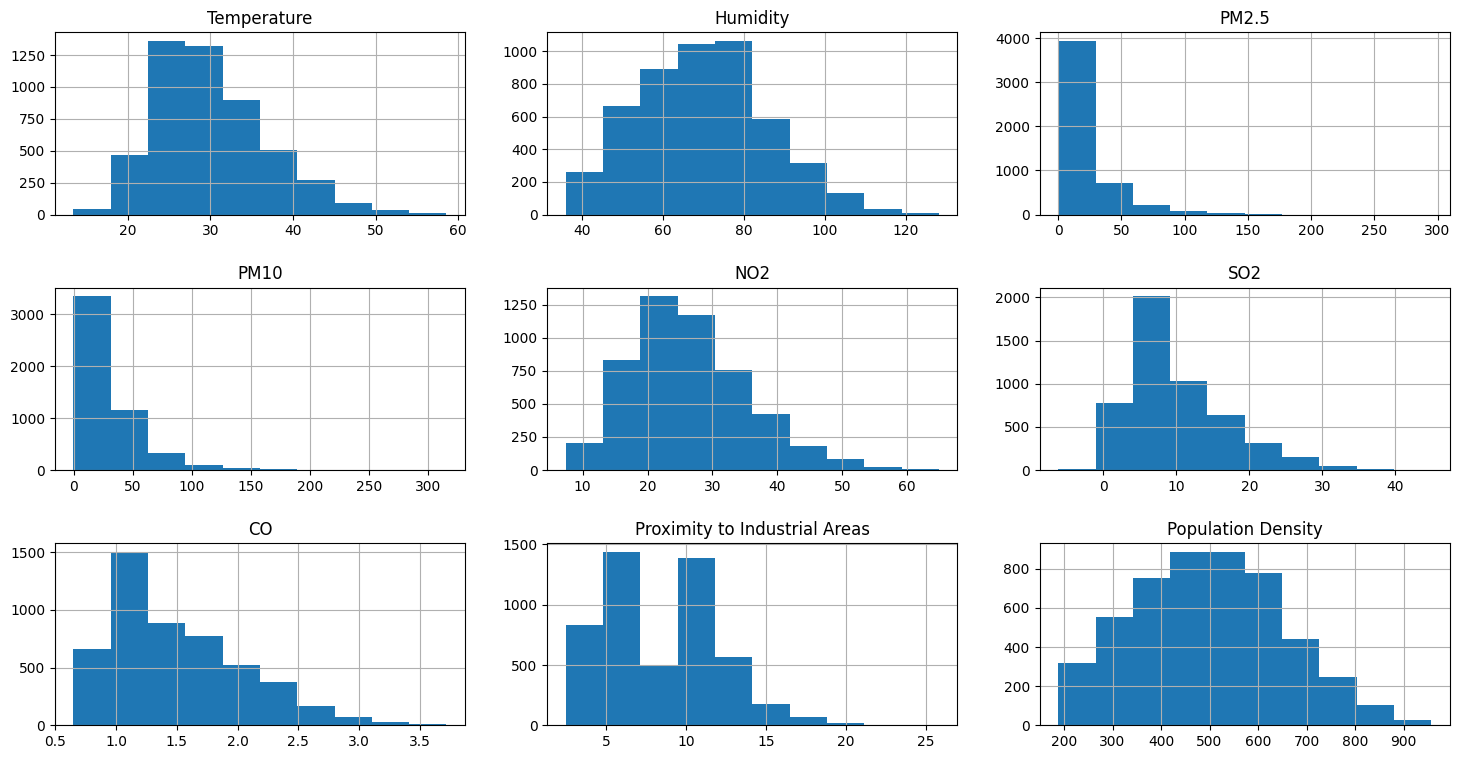

In [9]:
plt.figure(figsize=(18,9))
features = list(df_air.drop(columns=["Air Quality"]).columns)
count = 1
for f in features:
    ax = plt.subplot(3,3, count)
    df_air[f].hist()
    ax.set_title(f.replace("_", " "))
    count += 1

plt.subplots_adjust(hspace=0.4)

#### Classi
sbilanciate verso in ordine di pericolosità

Text(0.5, 0, '')

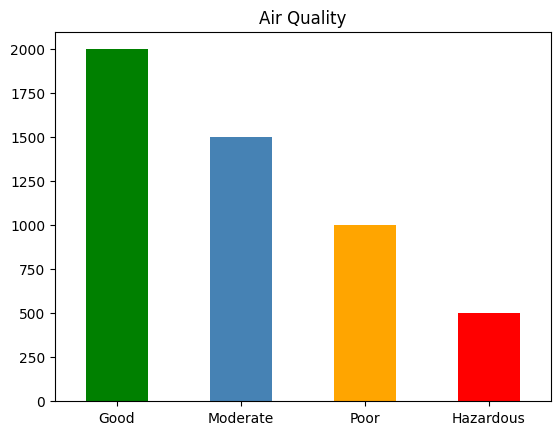

In [10]:
quality_count = df_air["Air Quality"].value_counts()
quality_count.plot(kind="bar", color=QUALITY_COLOR)
plt.title("Air Quality")
plt.xticks(rotation=0)
plt.xlabel("")

### Distribuzione dei valori in base alla classe

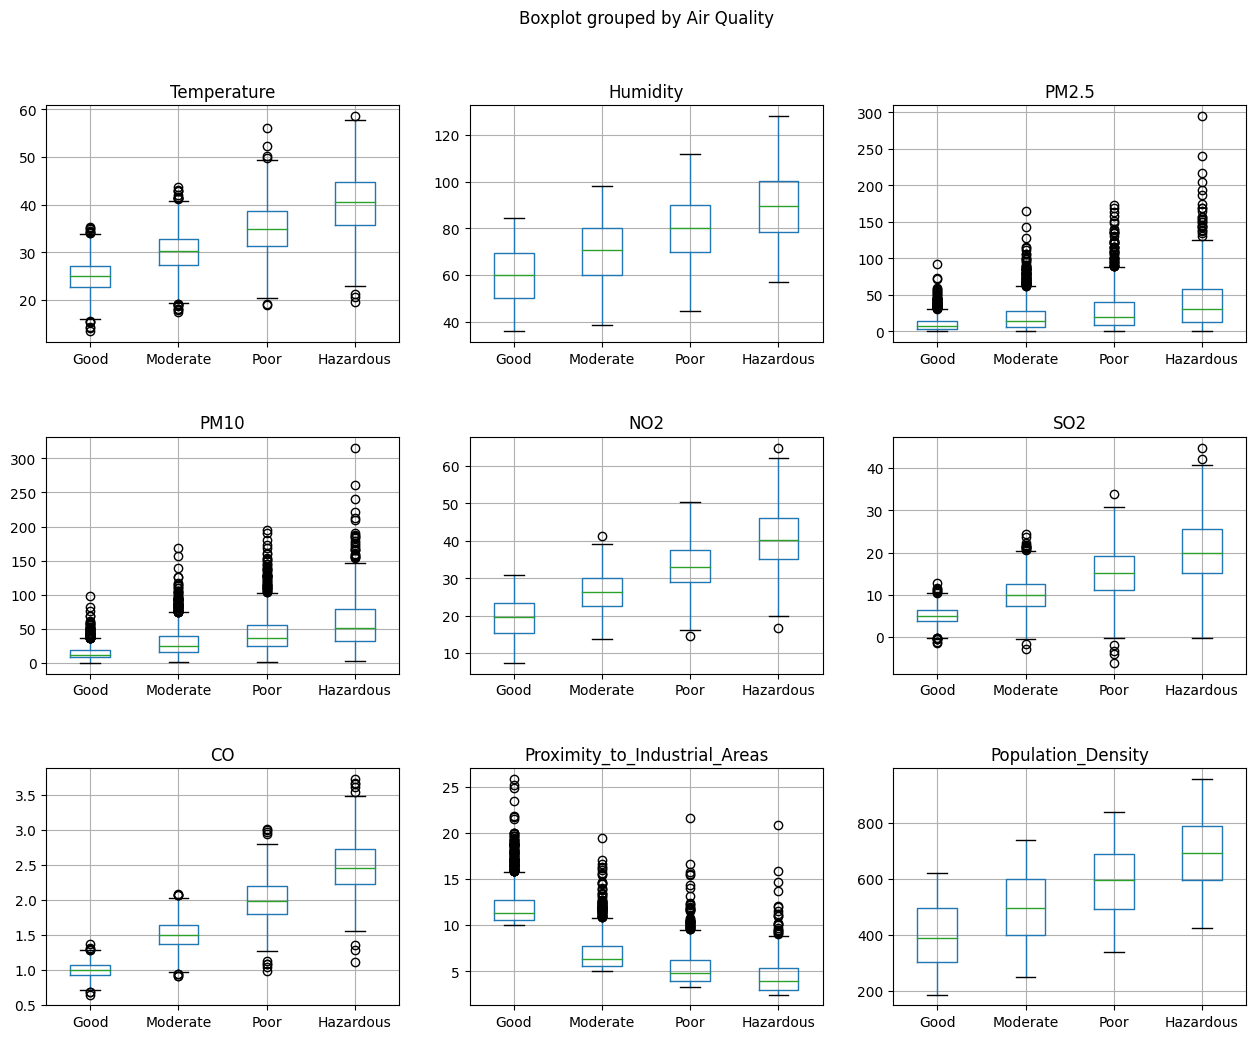

In [11]:
plt.figure(figsize=(15,12))
for i,f in enumerate(features):
    df_temp = df_air[[f, "Air Quality"]]
    ax = plt.subplot(3,3,i+1)
    df_temp.boxplot(by="Air Quality", ax=ax)
    ax.set_xlabel("")

plt.subplots_adjust(hspace=0.4)

### Correlazione tra le feature

- P2.5 e P10 altamente correlati
- i tre inquinanti (NO2, SO2, CO) sono abbastanza correlati insieme alla temperatura
- la distanza dall'area industriale è correlata molto negativamente con tutte le altre feature, in particolare inquinanti e temperatura
- Non c'è molta correlazione tra le PM, soprattutto 2.5, e le altre feature

In [12]:
corr_feat = df_air.drop(columns=["Air Quality"]).corr()
corr_feat

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
Temperature,1.000000,0.466456,0.323840,0.425690,0.591969,0.568082,0.685258,-0.589564,0.481692
Humidity,0.466456,1.000000,0.273366,0.359156,0.491977,0.459804,0.567540,-0.479646,0.411630
PM2.5,0.323840,0.273366,1.000000,0.973005,0.333004,0.299582,0.395179,-0.315766,0.278957
PM10,0.425690,0.359156,0.973005,1.000000,0.439916,0.401849,0.518895,-0.425018,0.365734
NO2,0.591969,0.491977,0.333004,0.439916,1.000000,0.571839,0.710792,-0.607710,0.510938
SO2,0.568082,0.459804,0.299582,0.401849,0.571839,1.000000,0.679060,-0.570385,0.475242
CO,0.685258,0.567540,0.395179,0.518895,0.710792,0.679060,1.000000,-0.707581,0.593389
Proximity_to_Industrial_Areas,-0.589564,-0.479646,-0.315766,-0.425018,-0.607710,-0.570385,-0.707581,1.000000,-0.498058
Population_Density,0.481692,0.411630,0.278957,0.365734,0.510938,0.475242,0.593389,-0.498058,1.000000


<AxesSubplot: >

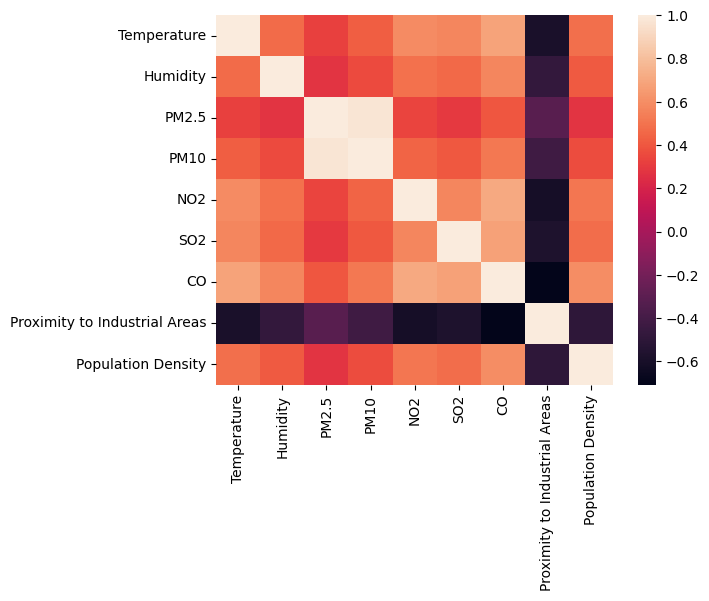

In [13]:
features_label = [ f.replace("_", " ") for f in features]
sns.heatmap(corr_feat, 
                xticklabels=features_label,
                yticklabels=features_label)

### Classi nello spazio

Si prova a vedere come sono disposte le classi nello spazio delle features

In [14]:
def scatter_pollution(df, x, y, size=None, mult_size=1.0, s=10,title="", ax=None):
    for i, quality in enumerate(QUALITY_ORDER):
        df_temp = df[df["Air Quality"] == quality]
        if size:
            plt.scatter(
                df_temp[x],
                df_temp[y],
                df_temp[size]*mult_size,
                label=quality,
                color=QUALITY_COLOR[i],
                edgecolors="black"
            )
        else:
            plt.scatter(
                df_temp[x],
                df_temp[y],
                label=quality,
                s=s,
                color=QUALITY_COLOR[i],
                edgecolors="black"

            )
        if ax:
            ax.set_title(title)
            ax.set_xlabel(x)
            ax.set_ylabel(y)
        else:
            plt.title(title)
            plt.xlabel(x)
            plt.ylabel(y)
        plt.legend()

##### Prossimità, densità e temperatura

- si nota che ci sono dei gradini in base alla prossimità 
- solitamente dove fa più caldo c'è anche più inquinamento
- si nota anche che le città con la peggiore aria sono quelle

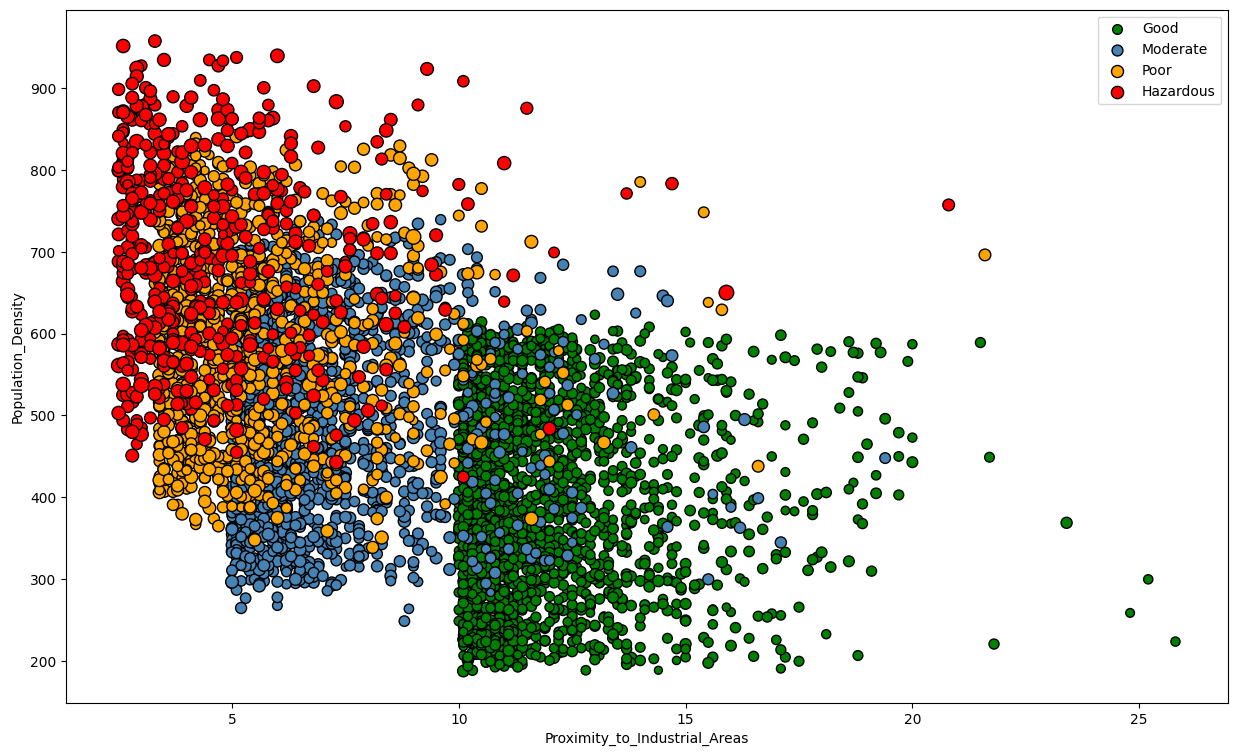

In [15]:
plt.figure(figsize=(15,9))
scatter_pollution(df_air, "Proximity_to_Industrial_Areas", "Population_Density", "Temperature", mult_size=2)

#### Inquinanti

- NO2 le classi hanno intervalli consecuti con overlapping
- CO  Good abbastanza separato dal resto poi iniziano a mischiarsi le classi
- SO2 incrementalmente il range delle classi è sempre più grande e la media cresce

sembra un cono con punto doppio l'origine, poi sono disposti in maniera incrementale 

/home/mattinz/.local/lib/python3.10/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


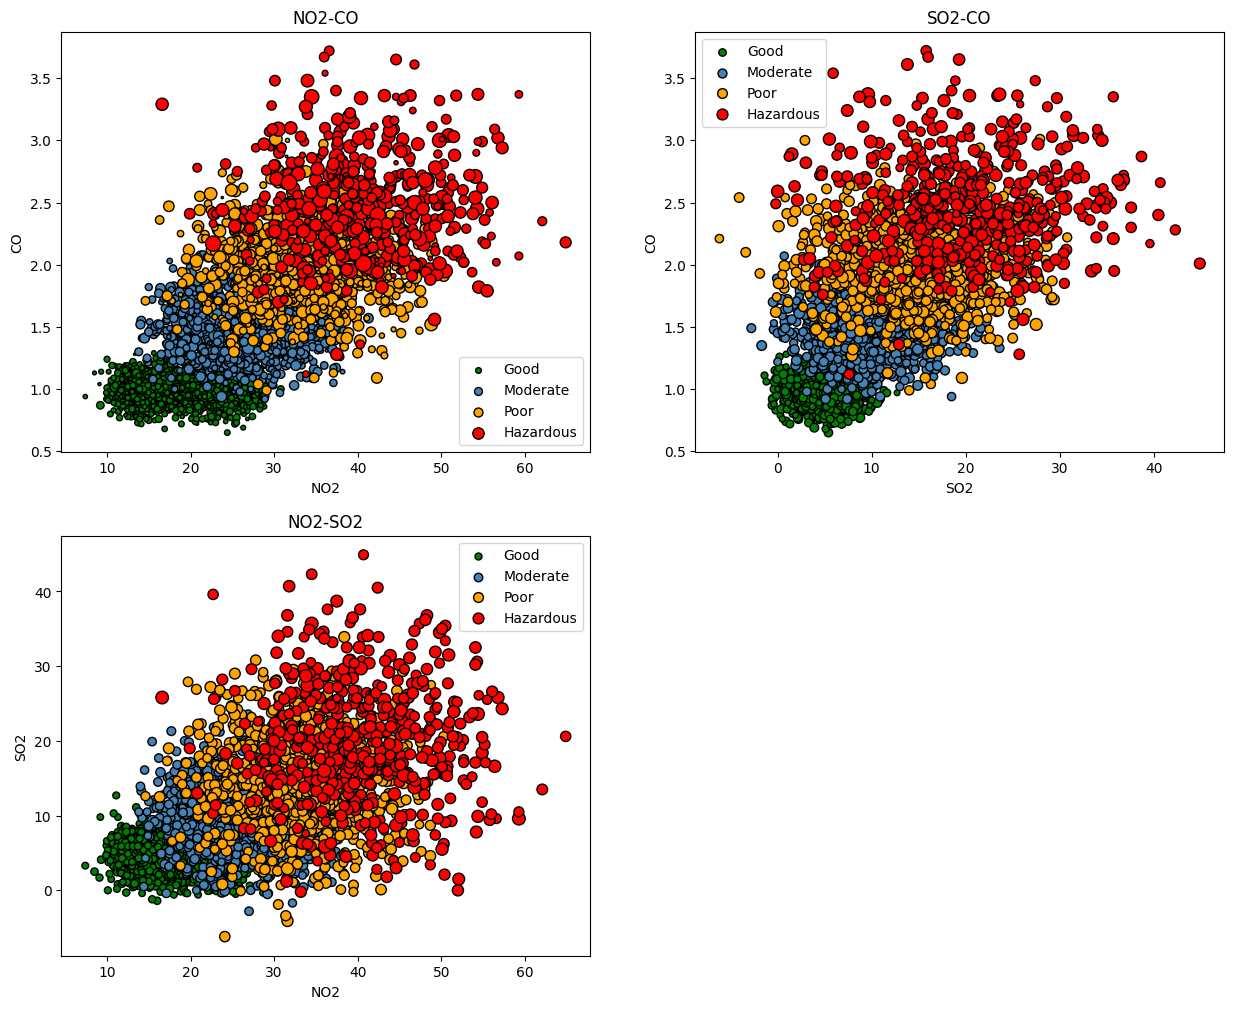

In [16]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
scatter_pollution(df_air, "NO2", "CO", "SO2", mult_size=3, title="NO2-CO")
plt.subplot(2,2,2)
scatter_pollution(df_air, "SO2", "CO","NO2", mult_size=1.5, title="SO2-CO")
plt.subplot(2,2,3)
scatter_pollution(df_air, "NO2", "SO2", "CO", mult_size=25, title="NO2-SO2")

Prendiamo NO2-CO-SO2 e lo tagliamo in base alla distanza

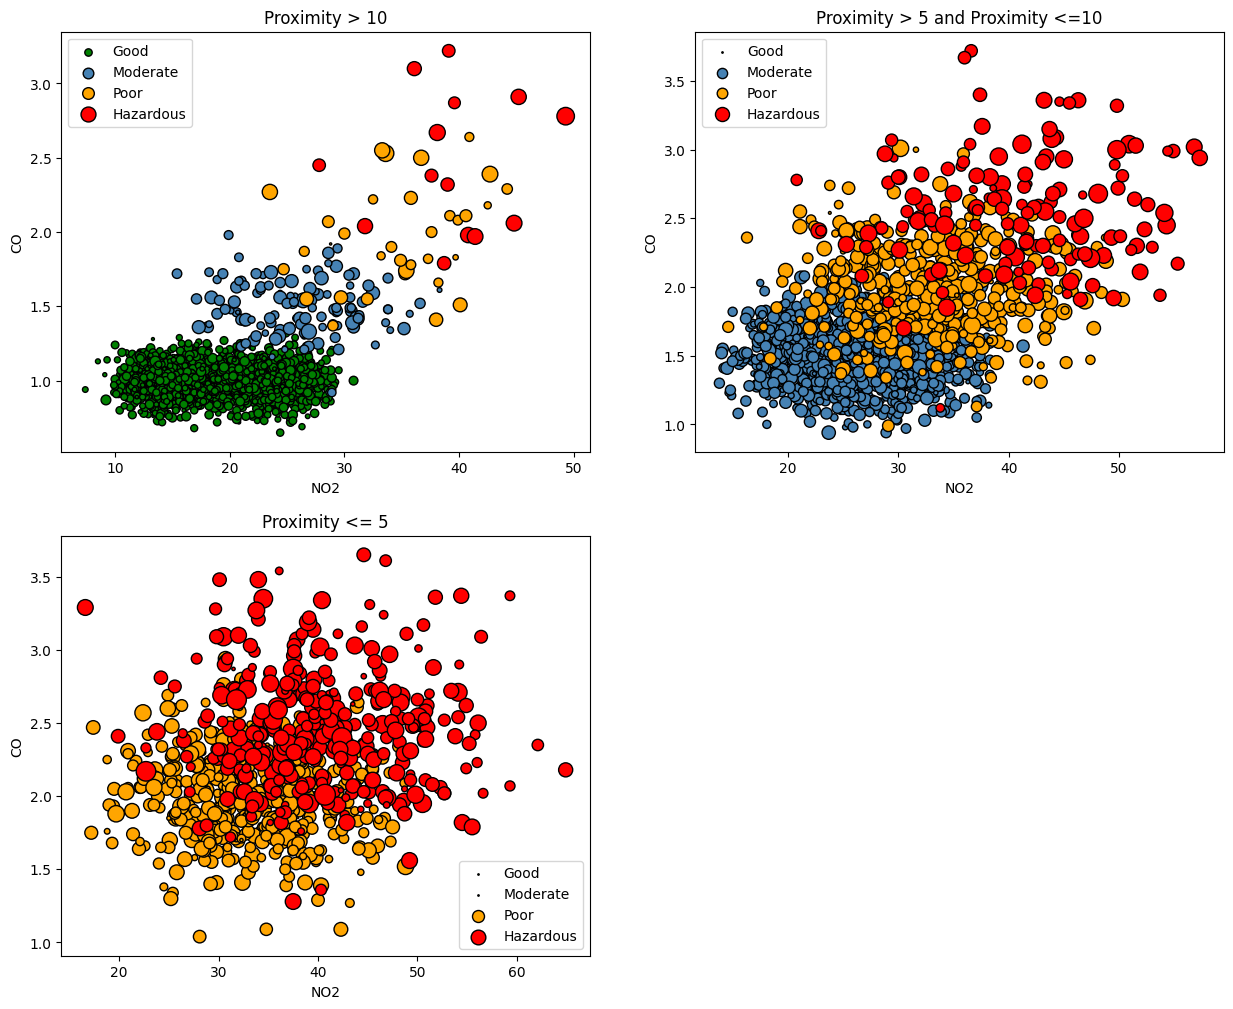

In [17]:
plt.figure(figsize=(15,12))
df_filter = df_air[df_air["Proximity_to_Industrial_Areas"]>=10]
plt.subplot(2,2,1)
scatter_pollution(df_filter, "NO2", "CO", "SO2", mult_size=5, title="Proximity > 10")
df_filter = df_air[(df_air["Proximity_to_Industrial_Areas"]>=5) &(df_air["Proximity_to_Industrial_Areas"]<10)]
plt.subplot(2,2,2)
scatter_pollution(df_filter, "NO2", "CO", "SO2", mult_size=5, title="Proximity > 5 and Proximity <=10")
df_filter = df_air[df_air["Proximity_to_Industrial_Areas"]<5]
plt.subplot(2,2,3)
scatter_pollution(df_filter, "NO2", "CO", "SO2", mult_size=5, title="Proximity <= 5")


## Preprocessing
SO2 negativo è causato da errori di misurazione, quindi i valori negativi li mettiamo a zero
Per alberi di decisione non è necessario scalare i dati, non lo facciamo perchè almeno possiamo interpretare i valori

In [20]:
df_air["SO2"] = df_air["SO2"].apply(lambda x: max(x,0))
y_cat = df_air[["Air Quality"]]
X = df_air.drop(columns=["Air Quality"])

ord_enc = OrdinalEncoder()
y = ord_enc.fit_transform(y_cat).ravel()
class_order=[0,2,3,1]
print(ord_enc.categories_)

[array(['Good', 'Hazardous', 'Moderate', 'Poor'], dtype=object)]


In [56]:
cat_min = ["CO", "NO2", "Proximity_to_Industrial_Areas"]
cat_mid = cat_min + ["SO2", "PM2.5"]

std_scaler = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=VAL_SPLIT, random_state=RANDOM_SEED)
Xn = std_scaler.fit_transform(X)
Xn_train = std_scaler.fit_transform(X_train)
Xn_val = std_scaler.fit_transform(X_val)

X_min = X.loc[:,cat_min]
Xn_min = std_scaler.fit_transform(X_min)
X_min_t = X_train.loc[:,cat_min]
Xn_min_t = std_scaler.fit_transform(X_min_t)
X_min_v = X_val.loc[:,cat_min]
Xn_min_v = std_scaler.fit_transform(X_min_v)

X_mid = X.loc[:,cat_mid]
Xn_mid = std_scaler.fit_transform(X_mid)
X_mid_t = X_train.loc[:,cat_mid]
Xn_mid_t = std_scaler.fit_transform(X_mid_t)
X_mid_v = X_val.loc[:,cat_mid]
Xn_mid_v = std_scaler.fit_transform(X_mid_v)

### Funzioni di utility

#### Plot della confusion matrix

In [74]:
def plot_confusion_matrix(y_true, y_pred):
    c_matrix = confusion_matrix(y_true, y_pred)
    print(c_matrix)
    sns.heatmap(c_matrix, xticklabels=tick_class, yticklabels=tick_class)

#### Boxplot cross validation scores

In [77]:
def boxplot_crossval_scores(min_score, mid_score, max_score, title):
    total_Score = np.concatenate([min_score, mid_score, max_score])
    y_min = np.min(total_Score)*0.999
    y_max = np.max(total_Score)*1.001
    plt.figure(figsize=(12,8))
    plt.subplot(1,3,1)
    plt.boxplot(min_score)
    plt.ylim((y_min, y_max))
    plt.title("min")
    plt.subplot(1,3,2)
    plt.boxplot(mid_score)
    plt.ylim(y_min, y_max)
    plt.title("mid")
    plt.subplot(1,3,3)
    plt.boxplot(max_score)
    plt.ylim((y_min, y_max))
    plt.title("max")
    plt.suptitle(title)

## Albero di decisione
- Gini o entropia o log_loss
- min sample split (quanti minimo per tagliare)
- min sample leaf (quanti ne servono almeno per un foglia (ridurre overfitting))
- max depth

- provare ad eliminare feature

In [57]:
tree_param_grid = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [3,5,7,9,15,20, None],
    "min_samples_split": [2, 5, 10, 50, 100, 250]
    }]

tree_param_list = []
tick_model = ["min","mid", "max"]
tick_class = ord_enc.categories_[0].tolist()
print(tick_class)

['Good', 'Hazardous', 'Moderate', 'Poor']


### Min

#### Grid search

In [58]:
tree_min_search_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    param_grid=tree_param_grid,
    cv=5,
    return_train_score=True
)
tree_min_search_grid.fit(X_min_t, y_train)
grid_best_params = tree_min_search_grid.best_params_
tree_param_list.append((grid_best_params["max_depth"], grid_best_params["min_samples_split"]))
print(grid_best_params)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 50, 'splitter': 'best'}


#### Cross validation

In [ ]:
min_tree_score =cross_val_score(
    DecisionTreeClassifier(
        criterion=grid_best_params["criterion"],
        max_depth=grid_best_params["max_depth"],
        min_samples_split=grid_best_params["min_samples_split"],
        random_state=RANDOM_SEED),
    X_min,
    y,
    cv=10
)
print(min_tree_score)

[0.92  0.916 0.918 0.912 0.908 0.934 0.918 0.916 0.914 0.924]


#### Matrice di confusione

[[614   0   4   0]
 [  0 119   3  26]
 [  4   0 415  33]
 [  0  49  28 205]]
[0.75467635 0.08317733 0.16214632]
CO


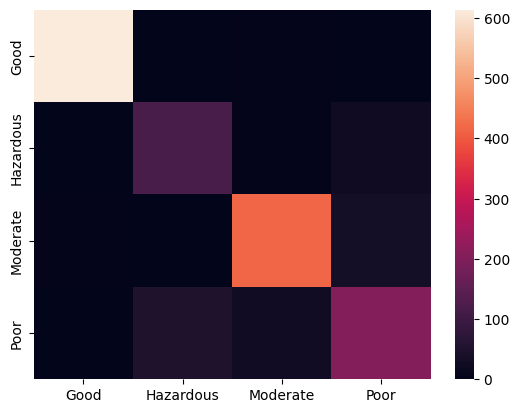

In [ ]:
min_tree = DecisionTreeClassifier(
    criterion=grid_best_params["criterion"],
    max_depth=grid_best_params["max_depth"],
    min_samples_split=grid_best_params["min_samples_split"],
    random_state=RANDOM_SEED
)
min_tree.fit(X_min_t, y_train)
y_pred = min_tree.predict(X_min_v)
plot_confusion_matrix(y_val, y_pred)

In [38]:
export_graphviz(
    min_tree,
    out_file="img/min_tree.dot",
    feature_names=cat_min
)
! dot -Tpng img/min_tree.dot > img/min_tree.png

### Mid

#### Grid Search

In [62]:
tree_mid_search_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    param_grid=tree_param_grid,
    cv=5,
    return_train_score=True
)
tree_mid_search_grid.fit(X_mid_t, y_train)
grid_best_params = tree_mid_search_grid.best_params_
tree_param_list.append((grid_best_params["max_depth"], grid_best_params["min_samples_split"]))
print(grid_best_params)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10, 'splitter': 'best'}


#### Cross Validation

In [63]:
mid_tree_score =cross_val_score(
    DecisionTreeClassifier(
        criterion=grid_best_params["criterion"],
        max_depth=grid_best_params["max_depth"],
        min_samples_split=grid_best_params["min_samples_split"],
        random_state=RANDOM_SEED),
    X_mid,
    y,
    cv=10
)
print(mid_tree_score)

[0.93  0.91  0.916 0.908 0.91  0.926 0.92  0.912 0.918 0.932]


#### Matrice di confusione

[[614   0   4   0]
 [  0 105   1  42]
 [  1   0 423  28]
 [  0  28  31 223]]


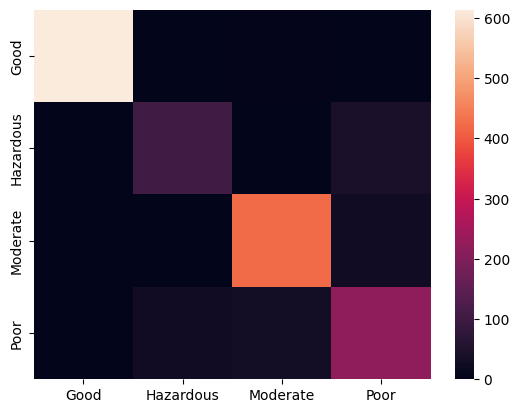

In [64]:
mid_tree = DecisionTreeClassifier(
    criterion=grid_best_params["criterion"],
    max_depth=grid_best_params["max_depth"],
    min_samples_split=grid_best_params["min_samples_split"],
    random_state=RANDOM_SEED
)
mid_tree.fit(X_mid_t, y_train)
y_pred = mid_tree.predict(X_mid_v)
plot_confusion_matrix(y_val, y_pred)

In [44]:
export_graphviz(
    mid_tree,
    out_file="img/mid_tree.dot",
    feature_names=cat_mid
)
! dot -Tpng img/mid_tree.dot > img/mid_tree.png

### Max

#### Grid Search

In [ ]:
tree_max_search_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    param_grid=tree_param_grid,
    cv=5,
    return_train_score=True
)
tree_max_search_grid.fit(X_train, y_train)
grid_best_params = tree_max_search_grid.best_params_
tree_param_list.append((grid_best_params["max_depth"], grid_best_params["min_samples_split"]))

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10, 'splitter': 'best'}


#### Cross Validation

In [ ]:
max_tree_score =cross_val_score(
    DecisionTreeClassifier(
        criterion=grid_best_params["criterion"],
        max_depth=grid_best_params["max_depth"],
        min_samples_split=grid_best_params["min_samples_split"],
        random_state=RANDOM_SEED),
    X,
    y,
    cv=10
)
print(max_tree_score)

array([0.928, 0.926, 0.938, 0.926, 0.926, 0.924, 0.922, 0.932, 0.926,
       0.932])

#### Matrice di confusione

[[616   0   2   0]
 [  0 117   2  29]
 [  2   0 415  35]
 [  0  28  24 230]]


array([0.02596842, 0.02630789, 0.00531251, 0.00737766, 0.04533677,
       0.02963359, 0.70690109, 0.13318382, 0.01997825])

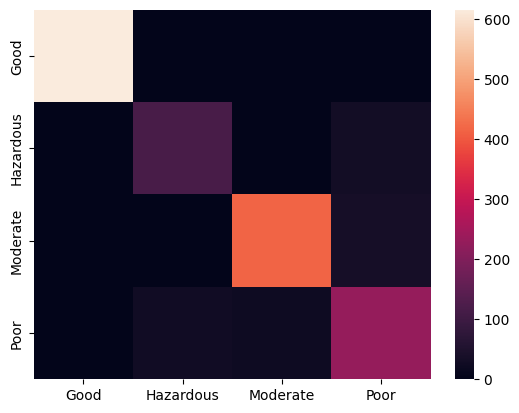

In [79]:
max_tree = DecisionTreeClassifier(
    criterion=grid_best_params["criterion"],
    max_depth=grid_best_params["max_depth"],
    min_samples_split=grid_best_params["min_samples_split"],
    random_state=RANDOM_SEED
)
max_tree.fit(X_train, y_train)
y_pred = max_tree.predict(X_val)
plot_confusion_matrix(y_val, y_pred)
max_tree.feature_importances_

In [48]:
export_graphviz(
    max_tree,
    out_file="img/max_tree.dot",
    feature_names=df_air.drop(columns=["Air Quality"]).columns
)
! dot -Tpng img/max_tree.dot > img/max_tree.png

### Evoluzione dei parametri

Text(0.5, 1.0, 'Numero minimo di elementi per la divisione')

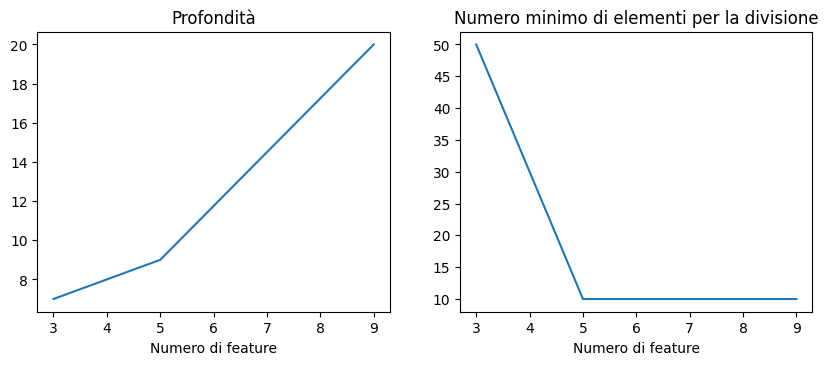

In [68]:
x_features = [3,5,9]
df_tree = pd.DataFrame(tree_param_list, columns=["max_depth", "min_samples_split"])
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x_features, df_tree["max_depth"])
plt.title("Profondità")
plt.xlabel("Numero di feature")
plt.subplot(2,2,2)
plt.plot(x_features, df_tree["min_samples_split"])
plt.xlabel("Numero di feature")
plt.title("Numero minimo di elementi per la divisione")

### Boxplot cross validation score

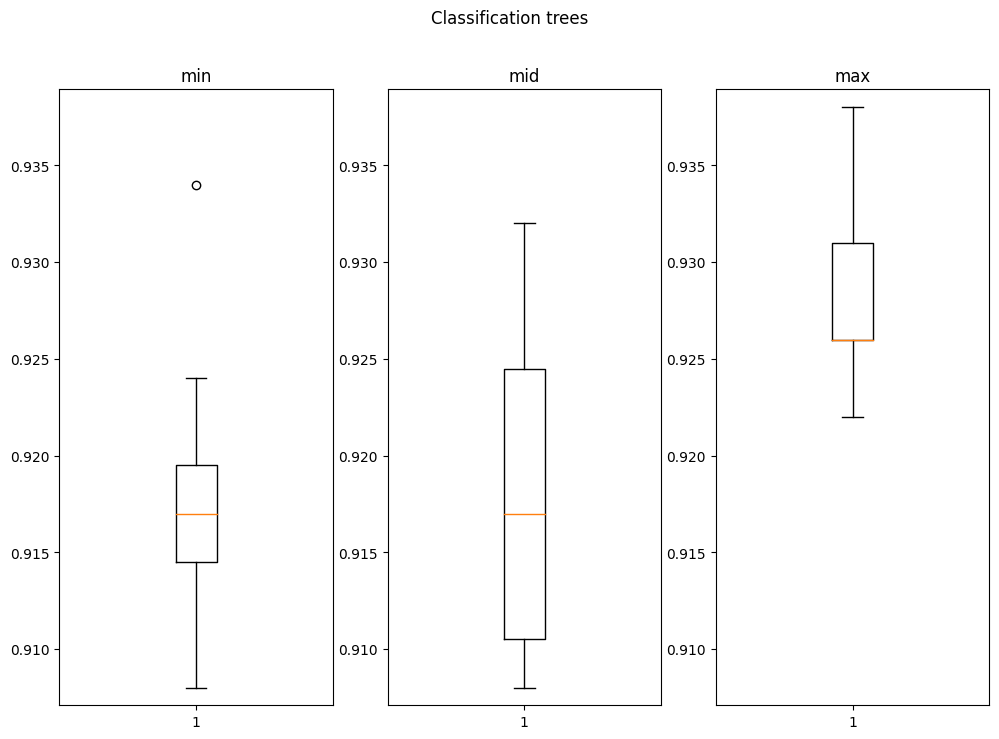

In [78]:
boxplot_crossval_scores(min_tree_score, mid_tree_score, max_tree_score, "Classification trees")

Text(0.5, 0.98, 'Feature importance')

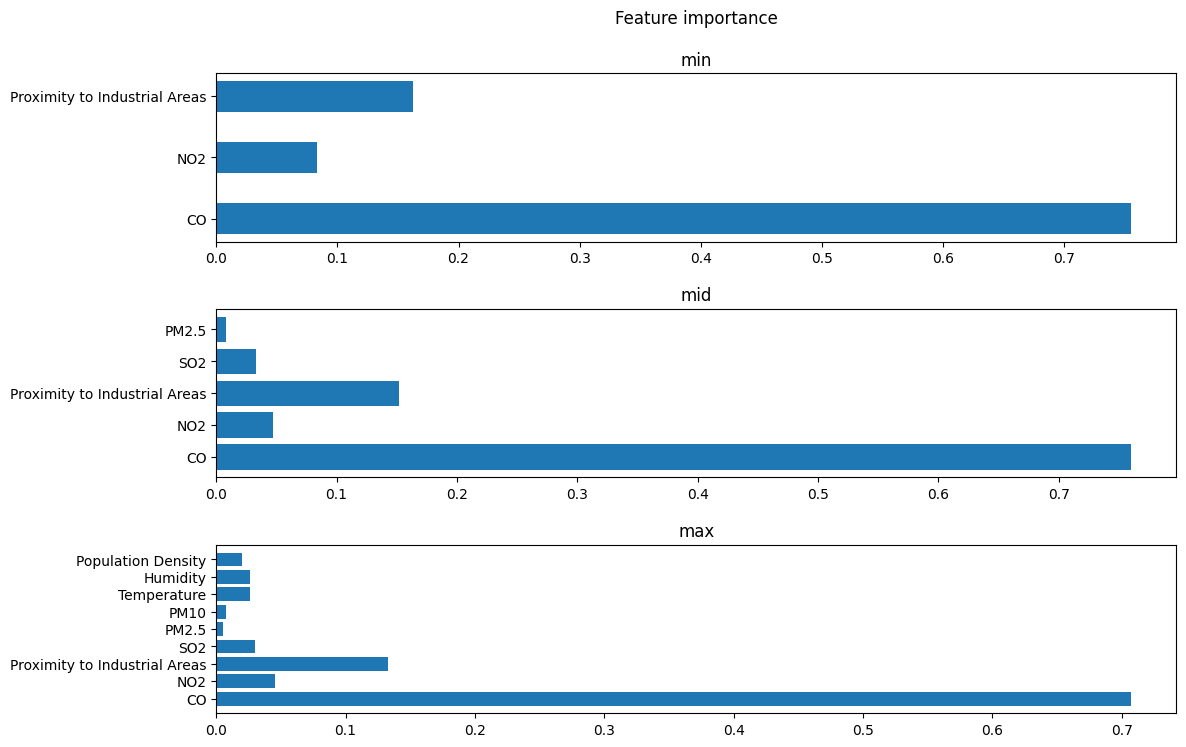

In [135]:
idx = [6,4,7,5,2,3,0,1,8]
min_features = [features_label[6], features_label[4],features_label[7]]
mid_features = min_features + [features_label[5], features_label[2]]
max_features = mid_features + [features_label[3], features_label[0], features_label[1],features_label[8]]
max_values = np.asarray(max_tree.feature_importances_)[idx]
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.barh(min_features, min_tree.feature_importances_,height = 0.5)
plt.title("min")
plt.subplot(3,1,2)
plt.barh(mid_features, mid_tree.feature_importances_)
plt.title("mid")
plt.subplot(3,1,3)
plt.barh(max_features, max_values)
plt.title("max")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
plt.suptitle("Feature importance")



# Da qui in poi rifare secondo lo schema del tree


## Random forest

- Gini o entropia
- max depth
- max tree

In [126]:
forest_param_grid = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [2, 5, 10, 25, 50, 100],
    "max_depth": [3,5,7,9,15,20, None],
    "min_samples_split": [2, 5, 10, 50, 100, 250]
    }]

forest_param_list = []
tick_model = ["min","mid", "max"]
tick_class = ord_enc.categories_[0].tolist()
print(tick_class)

['Good', 'Hazardous', 'Moderate', 'Poor']


### Min

#### Grid Search

In [127]:
forest_min_search_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED),
    param_grid=forest_param_grid,
    cv=5,
    return_train_score=True
)
forest_min_search_grid.fit(X_min_t, y_train)
grid_best_params = forest_min_search_grid.best_params_
forest_param_list.append((grid_best_params["max_depth"], grid_best_params["min_samples_split"]))
print(grid_best_params)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 50}


#### Cross Validation

In [129]:
min_forest_score =cross_val_score(
    RandomForestClassifier(
        criterion=grid_best_params["criterion"],
        max_depth=grid_best_params["max_depth"],
        min_samples_split=grid_best_params["min_samples_split"],
        n_estimators=grid_best_params["n_estimators"],
        random_state=RANDOM_SEED),
    X_min,
    y,
    cv=10
)
print(min_forest_score)

[0.924 0.922 0.93  0.92  0.916 0.944 0.93  0.916 0.916 0.928]


#### Matrice di confusione

[[615   0   3   0]
 [  0 113   2  33]
 [  4   0 421  27]
 [  0  23  27 232]]


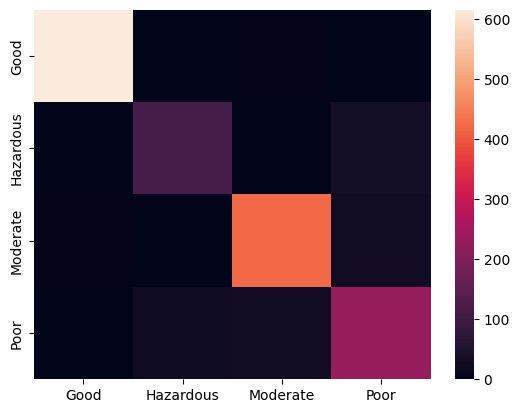

In [131]:
min_forest = RandomForestClassifier(
    criterion=grid_best_params["criterion"],
    max_depth=grid_best_params["max_depth"],
    min_samples_split=grid_best_params["min_samples_split"],
    n_estimators=grid_best_params["n_estimators"],
    random_state=RANDOM_SEED
)
min_forest.fit(X_min_t, y_train)
y_pred = min_forest.predict(X_min_v)
plot_confusion_matrix(y_val, y_pred)

#### Export

In [ ]:
#export_graphviz(
#    min_tree,
#    out_file="img/min_tree.dot",
#    feature_names=cat_min
#)
#! dot -Tpng img/min_tree.dot > img/min_tree.png

### Mid

#### Grid Search

In [132]:
forest_mid_search_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED),
    param_grid=forest_param_grid,
    cv=5,
    return_train_score=True
)
forest_mid_search_grid.fit(X_mid_t, y_train)
grid_best_params = forest_mid_search_grid.best_params_
forest_param_list.append((grid_best_params["max_depth"], grid_best_params["min_samples_split"]))
print(grid_best_params)

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 25}


#### Cross Validation

In [133]:
mid_forest_score =cross_val_score(
    RandomForestClassifier(
        criterion=grid_best_params["criterion"],
        max_depth=grid_best_params["max_depth"],
        min_samples_split=grid_best_params["min_samples_split"],
        n_estimators=grid_best_params["n_estimators"],
        random_state=RANDOM_SEED),
    X_mid,
    y,
    cv=10
)
print(mid_forest_score)

[0.938 0.934 0.948 0.94  0.926 0.954 0.942 0.926 0.926 0.934]


#### Matrice di confusione

[[616   0   2   0]
 [  0 119   1  28]
 [  1   0 425  26]
 [  0  30  20 232]]


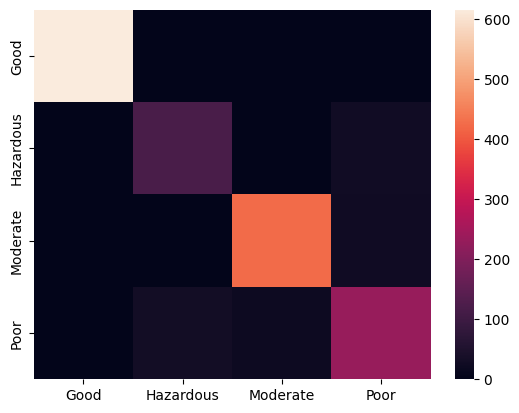

In [134]:
mid_forest = RandomForestClassifier(
    criterion=grid_best_params["criterion"],
    max_depth=grid_best_params["max_depth"],
    min_samples_split=grid_best_params["min_samples_split"],
    n_estimators=grid_best_params["n_estimators"],
    random_state=RANDOM_SEED
)
mid_forest.fit(X_mid_t, y_train)
y_pred = mid_forest.predict(X_mid_v)
plot_confusion_matrix(y_val, y_pred)

### Versione base

In [40]:
base_random_forest = RandomForestClassifier(random_state=RANDOM_SEED)
base_random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
base_forest_score = cross_val_score(
    RandomForestClassifier(
        random_state=RANDOM_SEED
    ),
    X,
    y,
    cv=10
)
base_forest_score

array([0.952, 0.952, 0.954, 0.96 , 0.956, 0.952, 0.952, 0.954, 0.956,
       0.95 ])

### Grid Search

In [42]:
forest_param_grid = [{
    "criterion": ["gini", "entropy"],
    "n_estimators": [2, 5, 10, 25, 50, 100],
    "max_depth": [3,5,7,9,15,20, None],
    "min_samples_split": [2, 5, 10, 50, 100, 150]
}]

forest_grid_search = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_SEED
    ),
    forest_param_grid,
    cv=5,
    return_train_score=True
)

forest_grid_search.fit(X, y)

forest_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_split': 5,
 'n_estimators': 25}

In [43]:
best_forest = RandomForestClassifier(
    n_estimators=25,
    criterion="gini",
    max_depth = 15,
    min_samples_split=5,
    random_state = RANDOM_SEED
)

best_forest_score = cross_val_score(
    best_forest,
    X,
    y,
    cv= 10
)

best_forest_score

array([0.956, 0.942, 0.952, 0.952, 0.942, 0.95 , 0.958, 0.96 , 0.96 ,
       0.948])

### Riduzione della dimensione

#### Min

In [44]:
min_forest_grid = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_SEED
    ),
    forest_param_grid,
    cv=5,
    return_train_score=True
)

min_forest_grid.fit(X_min, y)
min_forest_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 50}

In [45]:
min_forest = RandomForestClassifier(
    n_estimators=50,
    criterion="entropy",
    max_depth = 9,
    min_samples_split=5,
    random_state = RANDOM_SEED
)

min_forest_score = cross_val_score(
    min_forest,
    X_min,
    y,
    cv= 10
)

min_forest_score

array([0.928, 0.924, 0.924, 0.912, 0.922, 0.946, 0.926, 0.91 , 0.92 ,
       0.924])

#### 1

In [46]:
cat_1_forest_grid = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_SEED
    ),
    forest_param_grid,
    cv=5,
    return_train_score=True
)
cat_1_forest_grid.fit(X_cat_1, y)
cat_1_forest_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_split': 5,
 'n_estimators': 100}

In [47]:
cat_1_forest = RandomForestClassifier(
    n_estimators=100,
    criterion="entropy",
    max_depth = 15,
    min_samples_split=5,
    random_state = RANDOM_SEED
)

cat_1_forest_score = cross_val_score(
    cat_1_forest,
    X_cat_1,
    y,
    cv= 10
)

cat_1_forest_score

array([0.94 , 0.942, 0.944, 0.938, 0.932, 0.952, 0.938, 0.924, 0.934,
       0.936])

#### 2

In [48]:
cat_2_forest_grid = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_SEED
    ),
    forest_param_grid,
    cv=5,
    return_train_score=True
)
cat_2_forest_grid.fit(X_cat_2, y)
cat_2_forest_grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 5,
 'n_estimators': 100}

In [49]:
cat_2_forest = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth = 20,
    min_samples_split=5,
    random_state = RANDOM_SEED
)

cat_2_forest_score = cross_val_score(
    cat_2_forest,
    X_cat_2,
    y,
    cv= 10
)

cat_2_forest_score

array([0.956, 0.95 , 0.956, 0.956, 0.948, 0.952, 0.958, 0.956, 0.958,
       0.952])

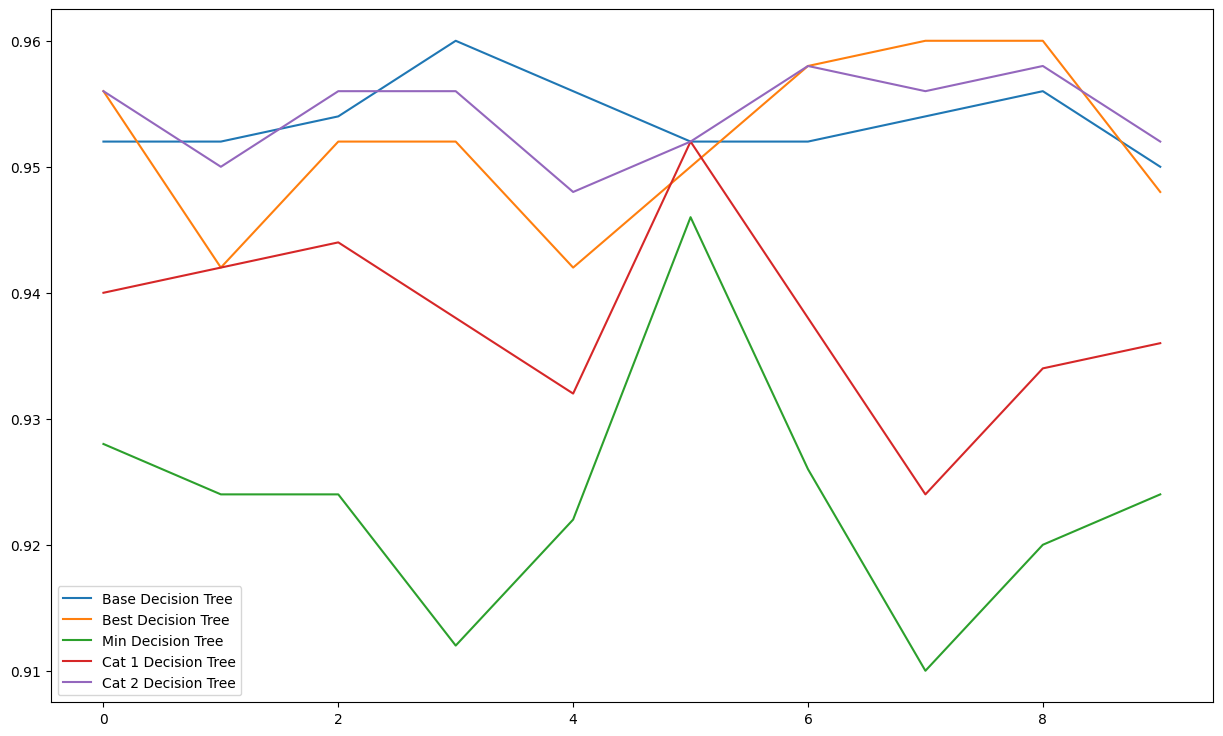

In [50]:
plt.figure(figsize=(15,9))
x_axis = np.arange(10)
plt.plot(x_axis, base_forest_score, label="Base Decision Tree")
plt.plot(x_axis, best_forest_score, label="Best Decision Tree")
plt.plot(x_axis, min_forest_score, label="Min Decision Tree")
plt.plot(x_axis, cat_1_forest_score, label="Cat 1 Decision Tree")
plt.plot(x_axis, cat_2_forest_score, label="Cat 2 Decision Tree")

plt.legend()

## SVC 1vs1

In [51]:
svc_param_grid = [{
    "C": [1.0, 2.0, 5.0, 10.0, 50.0 ]
}]

In [52]:
std_scaler = StandardScaler()
X_norm = std_scaler.fit_transform(X)

base_svc_ovo = svm.SVC(decision_function_shape="ovo")

svc_ovo_score = cross_val_score(base_svc_ovo, X_norm, y, cv=10)
svc_ovo_score

array([0.938, 0.936, 0.948, 0.962, 0.938, 0.944, 0.936, 0.944, 0.948,
       0.944])

In [53]:
svc_grid_search = GridSearchCV(
    svm.SVC(decision_function_shape="ovo"),
    svc_param_grid
)

svc_grid_search.fit(X_norm, y)
svc_grid_search.best_params_

{'C': 1.0}

### Senza normalizzazione

In [54]:
svc_ovo_score_no_norm = cross_val_score(base_svc_ovo, X, y, cv=10)
svc_ovo_score_no_norm

array([0.786, 0.782, 0.802, 0.732, 0.776, 0.758, 0.754, 0.772, 0.78 ,
       0.77 ])

In [55]:
svc_grid_search.fit(X, y)
svc_grid_search.best_params_

{'C': 50.0}

In [56]:
svc_ovo_score_no_norm_c = cross_val_score(
    svm.SVC(C=10, decision_function_shape="ovo"),
    X,
    y,
    cv=10
)
svc_ovo_score_no_norm_c

array([0.884, 0.886, 0.906, 0.896, 0.906, 0.864, 0.862, 0.894, 0.91 ,
       0.876])

### Min

In [57]:
X_min_norm = std_scaler.fit_transform(X_min)
X_cat_1_norm = std_scaler.fit_transform(X_cat_1)
X_cat_2_norm = std_scaler.fit_transform(X_cat_2)

In [58]:
svc_ovo_min_grid = GridSearchCV(
    svm.SVC(decision_function_shape="ovo"),
    svc_param_grid
)

svc_ovo_min_grid.fit(X_min_norm, y)
svc_ovo_min_grid.best_params_

{'C': 50.0}

In [59]:
svc_ovo_min_score = cross_val_score(
    svm.SVC(C=50, decision_function_shape="ovo"),
    X_norm,
    y,
    cv=10
)

svc_ovo_min_score

array([0.922, 0.932, 0.94 , 0.95 , 0.944, 0.936, 0.932, 0.926, 0.956,
       0.936])

### 1

In [60]:
svc_ovo_cat_1_grid = GridSearchCV(
    svm.SVC(decision_function_shape="ovo"),
    svc_param_grid
)

svc_ovo_cat_1_grid.fit(X_cat_1_norm, y)
svc_ovo_cat_1_grid.best_params_

{'C': 2.0}

In [61]:
svc_ovo_cat_1_score = cross_val_score(
    svm.SVC(C=2, decision_function_shape="ovo"),
    X_norm,
    y,
    cv=10
)

svc_ovo_cat_1_score

array([0.932, 0.932, 0.946, 0.958, 0.942, 0.942, 0.94 , 0.942, 0.952,
       0.944])

### 2

In [62]:
svc_ovo_cat_2_grid = GridSearchCV(
    svm.SVC(decision_function_shape="ovo"),
    svc_param_grid
)

svc_ovo_cat_2_grid.fit(X_cat_2_norm, y)
svc_ovo_cat_2_grid.best_params_

{'C': 1.0}

In [63]:
svc_ovo_cat_2_score = cross_val_score(
    svm.SVC(C=1, decision_function_shape="ovo"),
    X_norm,
    y,
    cv=10
)

svc_ovo_cat_2_score

array([0.938, 0.936, 0.948, 0.962, 0.938, 0.944, 0.936, 0.944, 0.948,
       0.944])

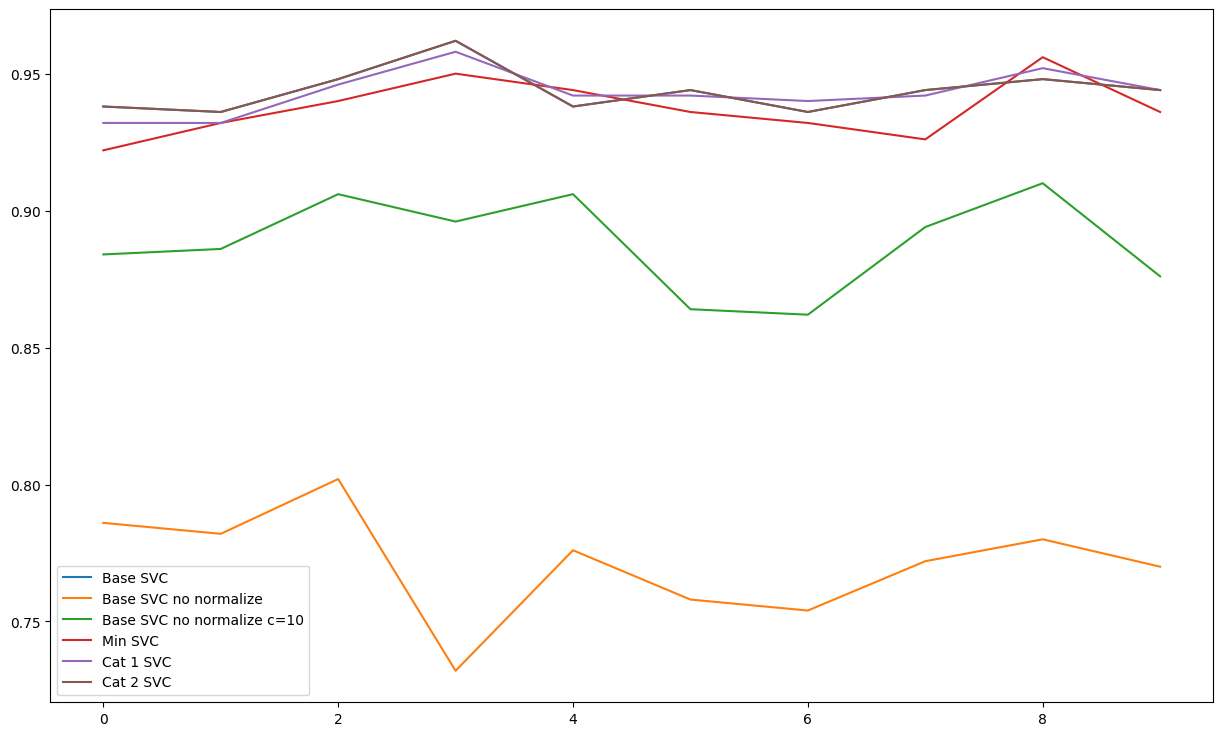

In [64]:
plt.figure(figsize=(15,9))

plt.plot(x_axis, svc_ovo_score, label="Base SVC")
plt.plot(x_axis, svc_ovo_score_no_norm, label="Base SVC no normalize")
plt.plot(x_axis, svc_ovo_score_no_norm_c, label="Base SVC no normalize c=10")
plt.plot(x_axis, svc_ovo_min_score, label="Min SVC")
plt.plot(x_axis, svc_ovo_cat_1_score, label="Cat 1 SVC")
plt.plot(x_axis, svc_ovo_cat_2_score, label="Cat 2 SVC")

plt.legend()

Base SVC e Cat 2 SVC sono uguali

## SVC 1vsRest

In [65]:
base_svc_ovr = svm.SVC()

svc_ovr_score = cross_val_score(base_svc_ovr, X_norm, y, cv=10)
svc_ovr_score

array([0.938, 0.936, 0.948, 0.962, 0.938, 0.944, 0.936, 0.944, 0.948,
       0.944])

In [66]:
svc_ovr_min_grid = GridSearchCV(
    svm.SVC(),
    svc_param_grid
)

svc_ovr_min_grid.fit(X_min_norm, y)
svc_ovr_min_grid.best_params_

{'C': 50.0}

In [67]:
svc_ovo_min_grid = GridSearchCV(
    svm.SVC(decision_function_shape="ovr"),
    svc_param_grid
)

svc_ovo_min_grid.fit(X_min_norm, y)
svc_ovo_min_grid.best_params_

{'C': 50.0}

In [68]:
svc_ovr_cat_1_grid = GridSearchCV(
    svm.SVC(),
    svc_param_grid
)

svc_ovr_cat_1_grid.fit(X_cat_1_norm, y)
svc_ovr_cat_1_grid.best_params_

{'C': 2.0}

In [69]:
svc_ovr_cat_2_grid = GridSearchCV(
    svm.SVC(),
    svc_param_grid
)

svc_ovr_cat_2_grid.fit(X_cat_2_norm, y)
svc_ovr_cat_2_grid.best_params_

{'C': 1.0}

Abbiamo ottenuto gli stessi risultati usando le due diverse strategie

## SVC Iterativa

In [70]:
class CustomSVC(base.ClassifierMixin, base.BaseEstimator):

    def __init__(self, class_order, C_good=1, C_moderate=1, C_poor=1):
        self.class_order = class_order
        self.C_good = C_good
        self.C_moderate = C_moderate
        self.C_poor = C_poor
    
    def fit(self,X,y):
        X, y = validate_data(self,X,y)
        
        y_good = np.where(y==class_order[0], 1, 0)
        X_good = X 
        y_temp = y[np.nonzero(y_good-1)]
        y_moderate = np.where(y_temp == class_order[1], 1, 0)
        X_moderate = X[np.nonzero(y_good-1)]
        y_temp = y_temp[np.nonzero(y_moderate-1)]
        y_poor = np.where(y_temp==class_order[2], 1 , 0)
        X_poor = X_moderate[np.nonzero(y_moderate-1)]

        self.svc_good = svm.LinearSVC(C=self.C_good)
        self.svc_good.fit(X_good, y_good)
        self.svc_moderate = svm.LinearSVC(C=self.C_moderate)
        self.svc_moderate.fit(X_moderate, y_moderate)
        self.svc_poor = svm.LinearSVC(C=self.C_poor)
        self.svc_poor.fit(X_poor, y_poor)

        return self 
    
    def predict(self, X):
        y_pred = []
        X_np = np.array(X)
        for xt in X_np:
            x = xt.reshape(1,-1)
            y_good = self.svc_good.predict(x)
            if y_good == 1:
                y_pred.append(self.class_order[0])
                continue 

            y_moderate = self.svc_moderate.predict(x)
            if y_moderate == 1:
                y_pred.append(self.class_order[1])
                continue

            y_poor = self.svc_poor.predict(x)
            if y_poor == 1:
                y_pred.append(self.class_order[2])
            else:
                y_pred.append(self.class_order[3])

        return y_pred

In [71]:
class IterativeSVC(base.ClassifierMixin, base.BaseEstimator):

    def __init__(self, class_order, C=None):
        self.class_order = class_order
        if type(C) == list :
            if len(class_order)-1 != len(C):
                raise ValueError(f"C, {len(C)}, must have one item less than class_order, {len(class_order)}")
            self.C = C
        else:
            self.C = list(np.zeros(len(self.class_order)-1)+1)
        
        self.svcs = [ svm.LinearSVC(C=c) for c in self.C]

    
    def fit(self, X, y):
        X, y = validate_data(self,X, y)
        list_index_train = []
        X_np = np.array(X)
        for i in range(len(self.svcs)):
            y_temp = y
            X_class = X_np
            for l_index in list_index_train:
                y_temp = np.delete(y_temp, l_index, axis=0)
                X_class = np.delete(X_class, l_index, axis=0)
            
            # se è della classe y = 1
            y_class = np.where(y_temp == class_order[i], 1, 0)
            l_index = list(np.nonzero(y_class))
            list_index_train.append(l_index)
            #train
            self.svcs[i].fit(X_class, y_class)
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, reset=False)
        predictions = []
        X_np = np.array(X)
        for xt in X_np: 
            x = xt.reshape(1,-1)
            predicted = False
            for i in range(len(self.svcs)):
                y = self.svcs[i].predict(x)
                if y == 1:
                    predictions.append(self.class_order[i])
                    predicted = True
                    break
            if not predicted:
                predictions.append(self.class_order[-1])
            
        return np.array(predictions)
        

In [72]:
iterative_svc = IterativeSVC(class_order=[0,2,3,1], C=[1,1,1])
cross_val_score(iterative_svc, X, y, cv=10)

array([0.944, 0.924, 0.948, 0.952, 0.936, 0.94 , 0.932, 0.938, 0.96 ,
       0.932])

In [73]:
cross_val_score(iterative_svc, X_min, y, cv=10)

array([0.898, 0.89 , 0.916, 0.888, 0.902, 0.914, 0.904, 0.86 , 0.886,
       0.884])

In [74]:
cross_val_score(iterative_svc, X_min_norm, y, cv=10)

array([0.898, 0.888, 0.914, 0.892, 0.9  , 0.916, 0.904, 0.86 , 0.888,
       0.89 ])

In [75]:
cross_val_score(iterative_svc, X_cat_1, y, cv=10)

array([0.916, 0.908, 0.926, 0.924, 0.908, 0.916, 0.928, 0.892, 0.91 ,
       0.906])

In [76]:
cross_val_score(iterative_svc, X_cat_1_norm, y, cv=10)

array([0.918, 0.904, 0.926, 0.922, 0.908, 0.916, 0.93 , 0.892, 0.91 ,
       0.904])

In [77]:
cross_val_score(iterative_svc, X_cat_2,y, cv=10)

array([0.926, 0.92 , 0.946, 0.96 , 0.936, 0.932, 0.942, 0.928, 0.938,
       0.936])

In [78]:
cross_val_score(iterative_svc, X_cat_2_norm, y, cv=10)

array([0.924, 0.92 , 0.944, 0.954, 0.934, 0.936, 0.94 , 0.93 , 0.932,
       0.932])

In [79]:
isvc_param = [{
        "C": [
            [1,1,1],
            [1,1,2],
            [1,1,10],
            [1,10,50],
            [2,10,50],
            [10,10,10],
        ]
    }]

In [80]:
i_svc=IterativeSVC(class_order=[0,2,3,1])
isvc_grid_search = GridSearchCV(
    i_svc,
    param_grid=isvc_param
)

isvc_grid_search.fit(X, y)
isvc_grid_search.best_params_


{'C': [1, 1, 1]}

In [81]:
isvc_grid_search_min = GridSearchCV(
    IterativeSVC(class_order=[0,2,3,1]),
    isvc_param
)

isvc_grid_search_min.fit(X_min, y)
isvc_grid_search_min.best_params_

{'C': [1, 1, 1]}